In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import src.visuals as vs
from matplotlib import pyplot as plt
#from IPython.display import display # Allows the use of display() for DataFrames
from scipy.stats import norm
# Import supplementary visualizations code visuals.py
import lightgbm as lgb
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from collections import Counter

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from lightgbm.sklearn import LGBMClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score,fbeta_score,make_scorer,roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm
import pickle

from sklearn.externals import joblib
seed = 3

/Users/dwightliu/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/Users/dwightliu/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip instal

In [2]:
data = pd.read_csv('data/invest_data.csv')

In [3]:
data.head(10)

,cust_num,category,balance,age,acct_num,opendt
0,1,intl equity,7807.466667,86,1,14441
1,1,low equity,63069.166667,86,2,11091
2,1,high equity,9375.233333,86,3,12421
3,1,intl equity,21905.327778,86,4,12421
4,1,low equity,19276.511111,86,5,12423
5,1,intl equity,42149.294444,86,6,12449
6,1,intl equity,9559.744444,86,7,17528
7,1,intl equity,10420.422222,86,8,17528
8,1,intl equity,12268.450000,86,9,17528
9,1,intl equity,7165.194444,86,10,17553


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29473 entries, 0 to 29472
Data columns (total 6 columns):
cust_num    29473 non-null int64
category    29473 non-null object
balance     29473 non-null float64
age         29473 non-null int64
acct_num    29473 non-null int64
opendt      29473 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 1.3+ MB


## Data Quality Check

In [5]:
data.describe()

,cust_num,balance,age,acct_num,opendt
count,29473.000000,2.947300e+04,29473.000000,29473.000000,29473.000000
mean,6447.255420,1.270698e+04,57.341431,14737.000000,15877.614325
std,3986.232041,3.735675e+04,14.259308,8508.266578,1760.448330
min,1.000000,5.555556e-03,21.000000,1.000000,10959.000000
25%,2961.000000,1.941828e+03,47.000000,7369.000000,14487.000000
50%,6295.000000,4.906339e+03,57.000000,14737.000000,16376.000000
75%,9638.000000,1.221400e+04,67.000000,22105.000000,17358.000000
max,14310.000000,2.822422e+06,108.000000,29473.000000,18540.000000


### account number max is 29473 and totla record count is also 29473 which makes sense

In [6]:
data['cust_num'].nunique()

11587

In [7]:
data['cust_num'].unique()

array([    1,     2,     3, ..., 14307, 14308, 14310])

### the max of cust_num is 14310, however unique count of cust_num is only 11587
### we can see that cust_num is not strictly consecutive 

## Data Uniqueness Check

In [8]:
check = data.groupby('cust_num')[['age']].nunique()

In [9]:
check[check['age'] != 1]

,age
cust_num,


### double check this data is okay becasue every customer only has one age.

## create feature recency

In [10]:
#time on file (TOF) = time in years since the first recorded purchase (there may have been earlier purchases, but those were lost in a database upgrade …. this is real life!)
#recency = time in years since the most recent purchase
#freq = number of previous orders
#itemhist = number of previous items purchased
#monetary = total amount of previous purchases
#AOS = itemhist / freq = average order size in terms of items
#AOA = monetary / freq = average order amount in terms of Euros
#lambda = (TOF-recency)/(freq-1) = inter-purchase time
#AmtPerYr = monetary/TOF = amount spent per year

In [11]:
data.head(20)

,cust_num,category,balance,age,acct_num,opendt
0,1,intl equity,7807.466667,86,1,14441
1,1,low equity,63069.166667,86,2,11091
2,1,high equity,9375.233333,86,3,12421
3,1,intl equity,21905.327778,86,4,12421
4,1,low equity,19276.511111,86,5,12423
5,1,intl equity,42149.294444,86,6,12449
6,1,intl equity,9559.744444,86,7,17528
7,1,intl equity,10420.422222,86,8,17528
8,1,intl equity,12268.450000,86,9,17528
9,1,intl equity,7165.194444,86,10,17553


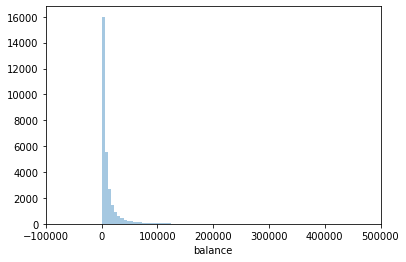

In [12]:
sns.distplot(data['balance'],kde = False,bins=500)
plt.xlim(xmin=-100000, xmax = 500000)
plt.show()

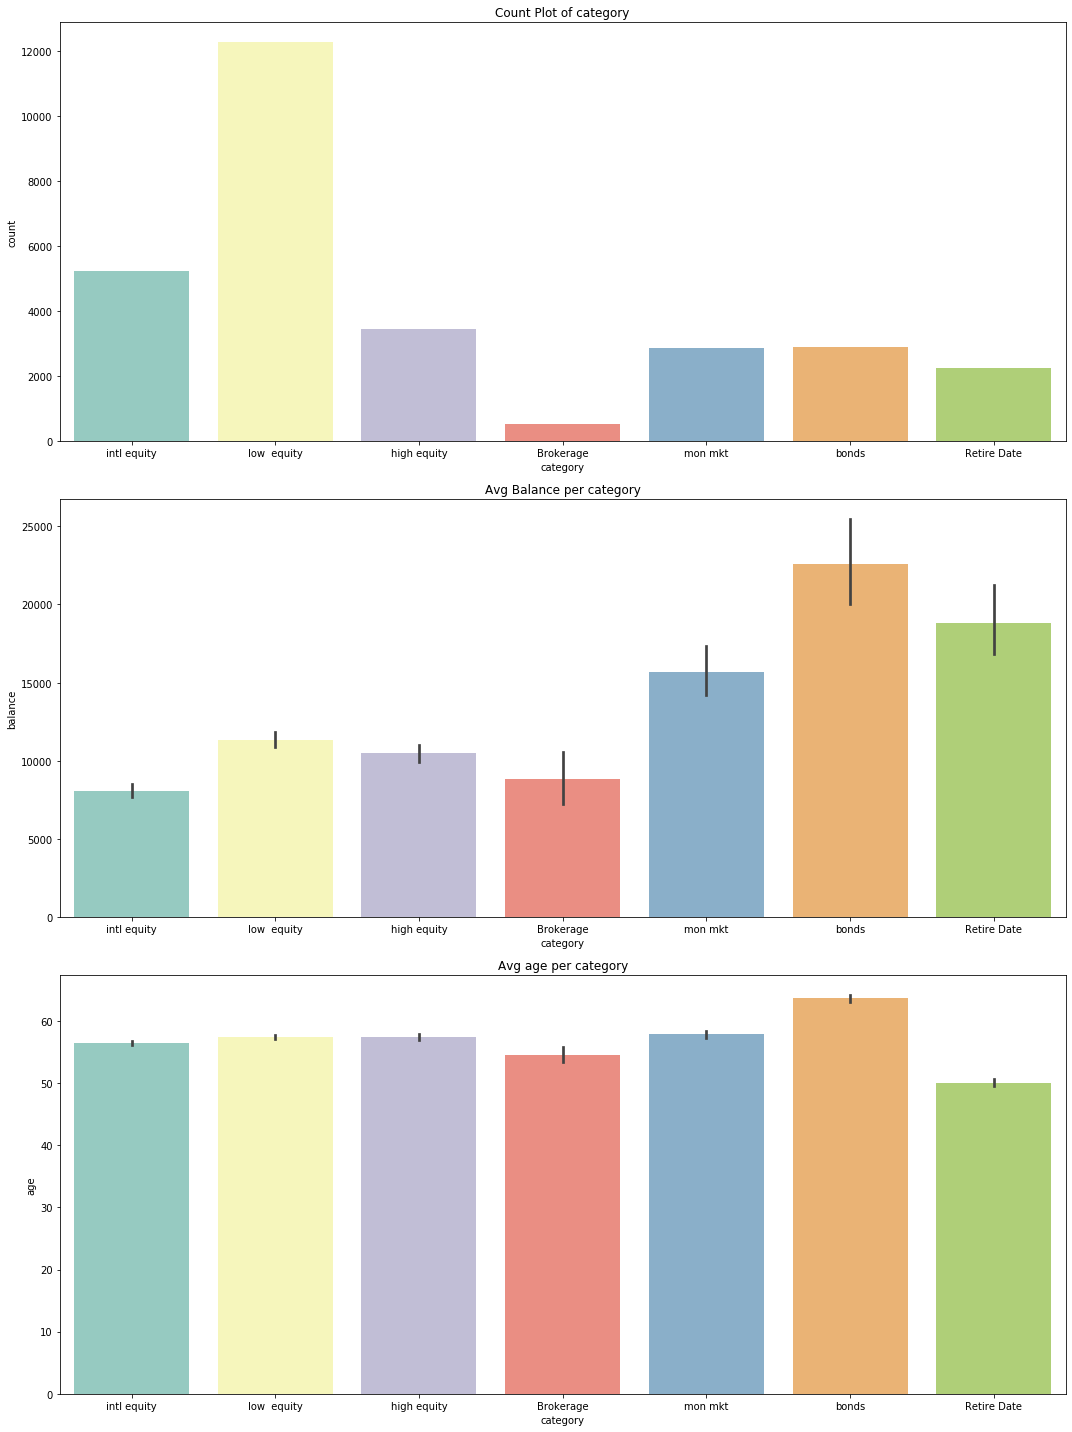

In [13]:
# Visualization of different countries
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 20))
sns.countplot(x='category', data=data, ax=ax[0],palette="Set3")
ax[0].set_title('Count Plot of category', fontsize=12)
#ax[0].set_yscale('log')
sns.barplot(x='category', y='balance', data=data, ax=ax[1],palette="Set3");
ax[1].set_title('Avg Balance per category', fontsize=12)
plt.tight_layout()
sns.barplot(x='category', y='age', data=data, ax=ax[2],palette="Set3");
ax[2].set_title('Avg age per category', fontsize=12)
plt.tight_layout()
plt.show()

In [14]:
customer_level = data.groupby('cust_num').agg(
{'opendt':['min','max'],
  'balance':'sum',
 'category':'size',
 'age':'min'
}
)

In [15]:
customer_level = customer_level.reset_index()

In [16]:
df = customer_level[['cust_num']].copy()
df['opendt_min'] = customer_level['opendt']['min']
df['opendt_max'] = customer_level['opendt']['max']
df['balance_sum'] = customer_level['balance']['sum']
df['account_count'] = customer_level['category']['size']
df['age'] = customer_level['age']['min']

In [17]:
df

,cust_num,opendt_min,opendt_max,balance_sum,account_count,age
,,,,,,
0,1,11091,17897,379021.911111,16,86
1,2,14224,14224,1449.255556,1,62
2,3,15008,17820,1475.783333,2,61
3,4,15732,17076,60263.144444,5,46
4,6,14075,17506,411608.994444,8,65
...,...,...,...,...,...,...
11582,14303,18260,18260,43772.816667,1,53
11583,14305,18261,18261,1111.511111,1,30
11584,14307,18261,18261,2754.000000,1,62


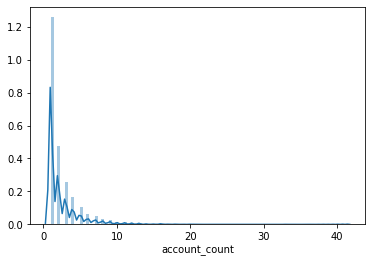

In [18]:
sns.distplot(df['account_count'],kde = True,bins=100)
plt.show()

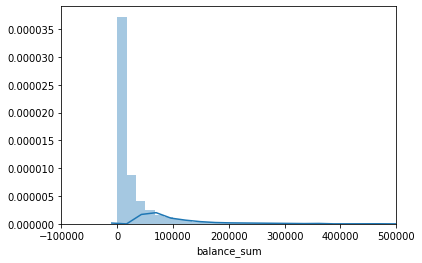

In [19]:
sns.distplot(df['balance_sum'],kde = True,bins=200)
plt.xlim(xmin=-100000, xmax = 500000)
plt.show()

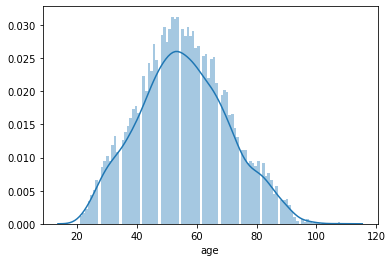

In [20]:
sns.distplot(df['age'],kde = True,bins=100)
plt.show()

In [21]:
df['AOA'] = df['balance_sum'] / df['account_count']
df['TOF'] = df['opendt_max'].max() - df['opendt_min']
df['lambda'] = (df['opendt_max'] - df['opendt_min'])/(df['account_count']-1)

In [22]:
df['lambda'] = df['lambda'].fillna(0)

In [23]:
# feature select account_count,AOA, TOF, lambda
cols = ['age','account_count','AOA','TOF','lambda']
df_clean = df[cols].copy()

/Users/dwightliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


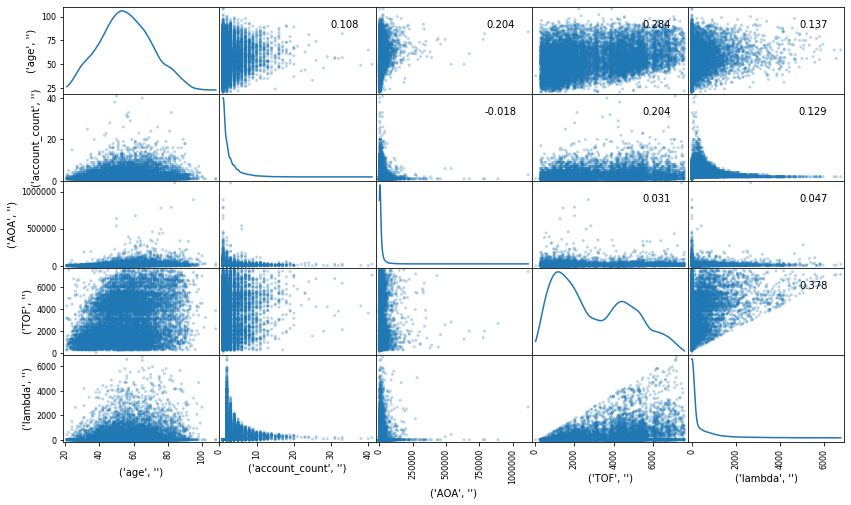

In [24]:
# Produce a scatter matrix for each pair of features in the data
axes = pd.plotting.scatter_matrix(df_clean, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
corr = df_clean.corr().as_matrix()

# put the correlation between each pair of variables on each graph
for i, j in zip(*np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i, j], (0.8, 0.8), xycoords="axes fraction", ha="center", va="center")

In [25]:
df_clean['log_account_count'] = np.log(1+df_clean['account_count'])
df_clean['log_AOA'] = np.log(1+df_clean['AOA'])
df_clean['log_lambda'] = np.log(1+df_clean['lambda'])

/Users/dwightliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


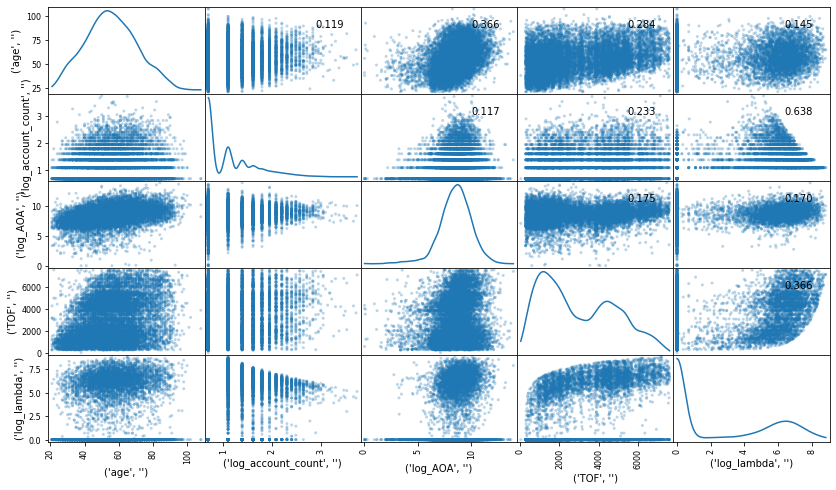

In [26]:
cols = ['age','log_account_count','log_AOA','TOF','log_lambda']
# Produce a scatter matrix for each pair of features in the data
axes = pd.plotting.scatter_matrix(df_clean[cols], alpha = 0.3, figsize = (14,8), diagonal = 'kde');
corr = df_clean[cols].corr().as_matrix()

# put the correlation between each pair of variables on each graph
for i, j in zip(*np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i, j], (0.8, 0.8), xycoords="axes fraction", ha="center", va="center")

In [27]:
log_data = df_clean[cols].copy()
# initializing the list of outlier indices, so outliers can be added for the loop
outliers  = []

# also initialize list of repeat outliers (outliers for more than one feature)
repeat_outliers = []

# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5 * (Q3 - Q1)
    
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    feature_outliers = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    display(feature_outliers)
    
    # append outlier indices to outliers array
    for i in feature_outliers.index:
        if i not in outliers:
            outliers.append(i)
        elif i not in repeat_outliers:
            repeat_outliers.append(i)
            
print("Number of outliers: ", len(outliers))
print("Outliers: ", outliers)
print("----------------------------------------------")
print("Number of repeat outliers: ", len(repeat_outliers))
print("Repeat outliers: ", repeat_outliers)
# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature '('age', '')':


,age,log_account_count,log_AOA,TOF,log_lambda
,,,,,
96,98,2.079442,10.157647,3464,5.415359
133,99,1.609438,10.929941,4533,7.210572
1118,98,1.609438,11.243341,1736,6.144901
2366,100,1.098612,9.814728,7039,0.000000
3786,100,1.098612,11.805896,4536,7.889084
4225,108,0.693147,10.237950,2227,0.000000
5752,98,0.693147,8.693565,4186,0.000000
7206,101,0.693147,10.291882,2346,0.000000
8297,98,1.098612,12.000367,5821,8.450198


Data points considered outliers for the feature '('log_account_count', '')':


,age,log_account_count,log_AOA,TOF,log_lambda
,,,,,
0,86,2.833213,10.072803,7449,6.119711
15,79,2.995732,10.181930,4463,5.445779
20,61,2.995732,9.786772,3815,5.285176
25,70,3.218876,10.609601,6523,5.523372
29,65,2.564949,9.126913,6775,6.105605
...,...,...,...,...,...
10937,83,2.484907,9.451426,648,0.000000
10964,68,2.564949,7.084457,4201,4.400045
11153,61,2.639057,10.238265,489,0.000000


Data points considered outliers for the feature '('log_AOA', '')':


,age,log_account_count,log_AOA,TOF,log_lambda
,,,,,
98,50,1.945910,13.195861,2843,6.067499
109,41,0.693147,0.005540,4058,0.000000
189,50,0.693147,3.853570,2771,0.000000
226,70,0.693147,12.754425,3912,0.000000
234,71,0.693147,12.702514,5690,0.000000
...,...,...,...,...,...
11513,34,0.693147,2.028148,326,0.000000
11522,21,0.693147,3.359990,288,0.000000
11535,36,0.693147,3.374549,299,0.000000


Data points considered outliers for the feature '('TOF', '')':


,age,log_account_count,log_AOA,TOF,log_lambda
,,,,,


Data points considered outliers for the feature '('log_lambda', '')':


,age,log_account_count,log_AOA,TOF,log_lambda
,,,,,


Number of outliers:  585
Outliers:  [96, 133, 1118, 2366, 3786, 4225, 5752, 7206, 8297, 8405, 11179, 0, 15, 20, 25, 29, 38, 40, 54, 59, 71, 73, 86, 107, 121, 135, 143, 151, 167, 209, 214, 239, 253, 260, 267, 277, 281, 286, 299, 314, 328, 402, 413, 570, 605, 665, 752, 755, 756, 760, 809, 861, 886, 1102, 1202, 1363, 1388, 1433, 1461, 1489, 1523, 1603, 1645, 1688, 1737, 1762, 1766, 1767, 1768, 1780, 1784, 1787, 1817, 1820, 1854, 1873, 1879, 1893, 1925, 1929, 1932, 1936, 1949, 1950, 1961, 1972, 1980, 1991, 1994, 2001, 2007, 2020, 2037, 2038, 2054, 2071, 2093, 2118, 2140, 2219, 2282, 2315, 2326, 2410, 2415, 2514, 2555, 2628, 2631, 2699, 2712, 2801, 2810, 2841, 2906, 2908, 2918, 2998, 3118, 3344, 3375, 3512, 3520, 3523, 3524, 3527, 3533, 3547, 3552, 3553, 3566, 3567, 3583, 3589, 3604, 3605, 3625, 3633, 3642, 3658, 3674, 3685, 3686, 3700, 3707, 3739, 3755, 3778, 3779, 3788, 3796, 3797, 3803, 3845, 3854, 3872, 3898, 3910, 4088, 4127, 4135, 4210, 4309, 4388, 4398, 4402, 4430, 4505, 4575, 4669, 

In [28]:
good_data.shape

(11002, 5)

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
good_data = scaler.fit_transform(good_data)
good_data = pd.DataFrame(good_data, columns = log_data.columns)

In [30]:
log_samples = good_data.sample(n=3)

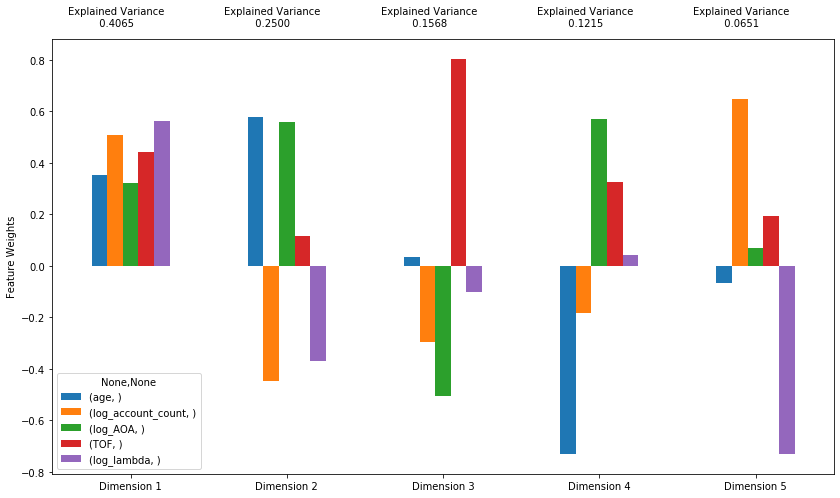

In [31]:
from sklearn.decomposition import PCA

# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=5).fit(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)


In [32]:
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5
0,-1.0878,0.6326,-0.2889,-0.1548,-0.1432
1,-1.0517,-0.7416,0.1968,0.1135,0.5296
2,-1.7603,-0.2177,0.0309,-1.1209,-0.3331


In [33]:
# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=3).fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2','Dimension 3'])

In [34]:
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2','Dimension 3']))

,Dimension 1,Dimension 2,Dimension 3
0,-1.0878,0.6326,-0.2889
1,-1.0517,-0.7416,0.1968
2,-1.7603,-0.2177,0.0309


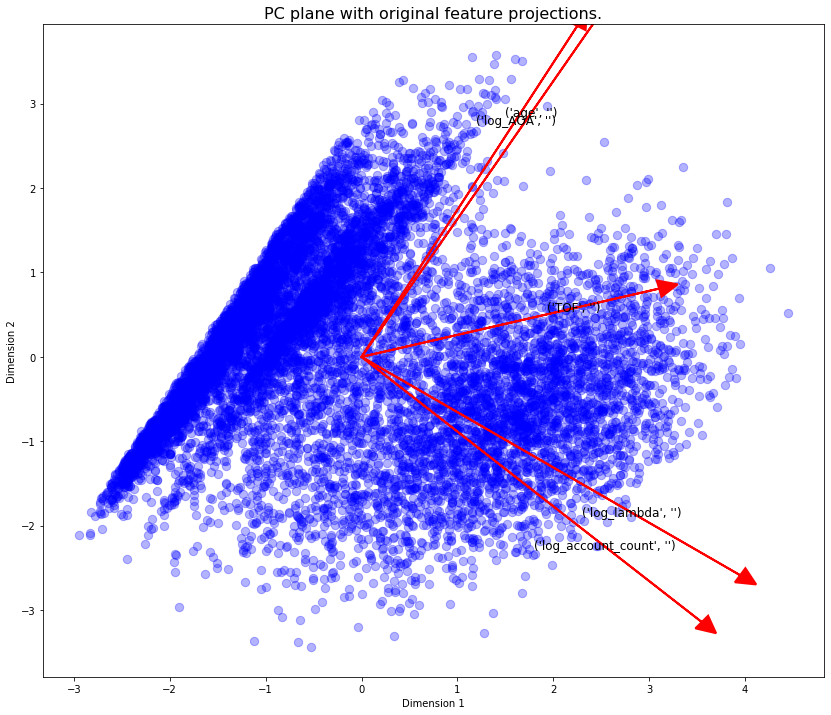

In [35]:
vs.biplot(good_data, reduced_data, pca)

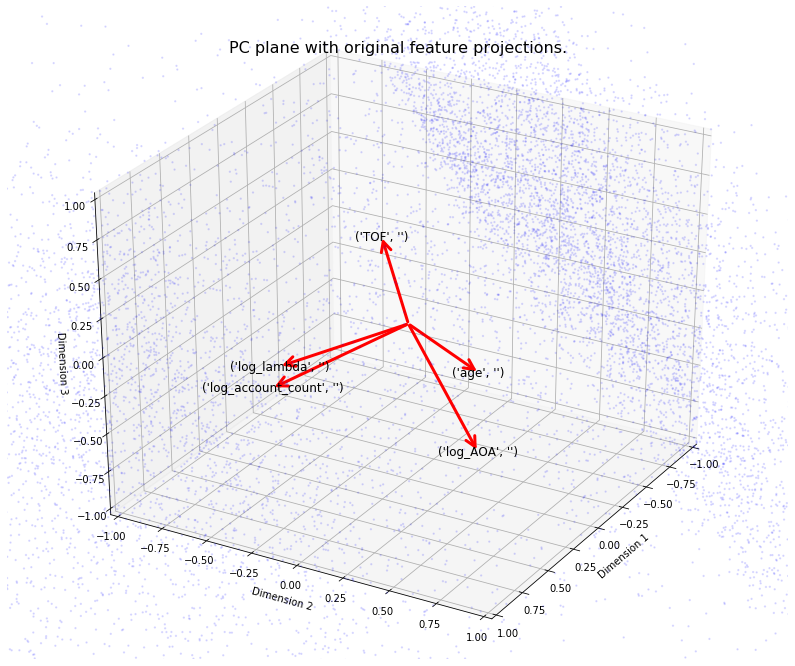

In [38]:
vs.threeplot(good_data, reduced_data, pca,30)

In [ ]:
reduced_data

For n_clusters = 2 The average silhouette_score is : 0.3785246174297567
For n_clusters = 3 The average silhouette_score is : 0.3396024865553767
For n_clusters = 4 The average silhouette_score is : 0.34730349434668956
For n_clusters = 5 The average silhouette_score is : 0.3376115928486691
For n_clusters = 6 The average silhouette_score is : 0.321910593143563


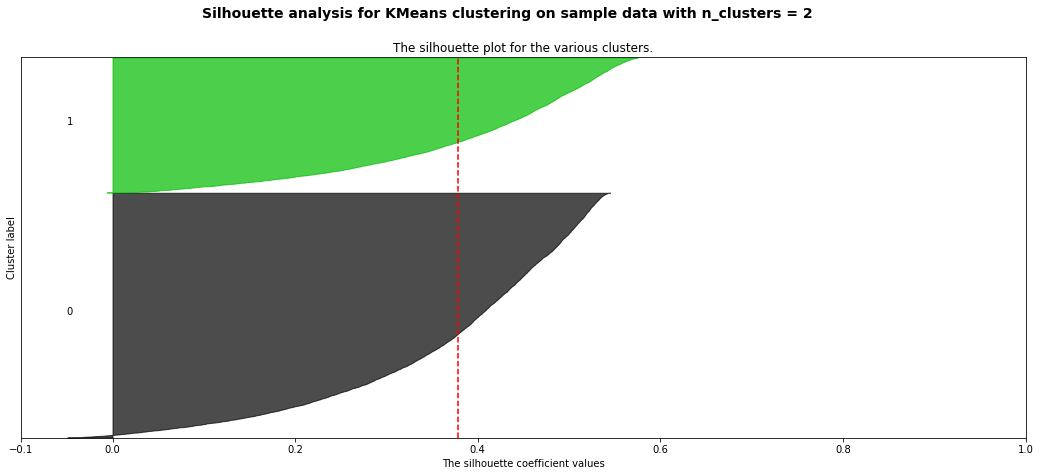

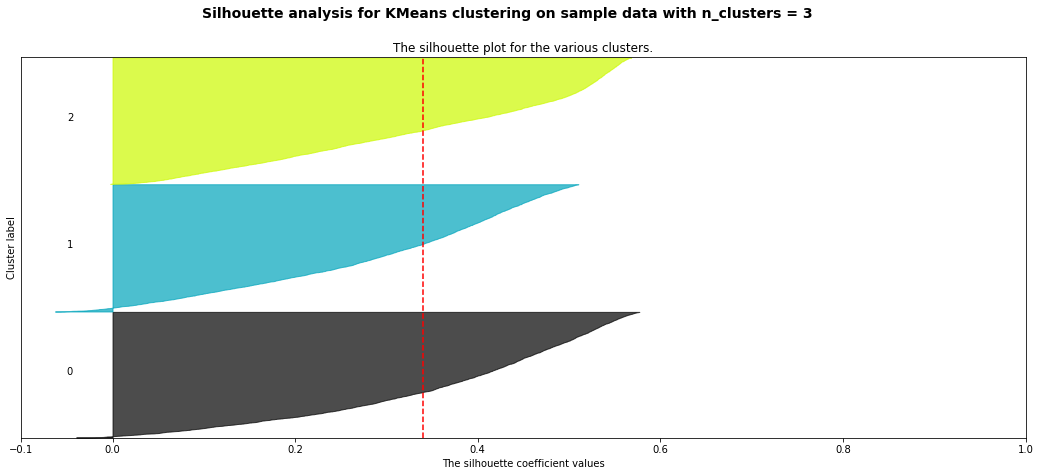

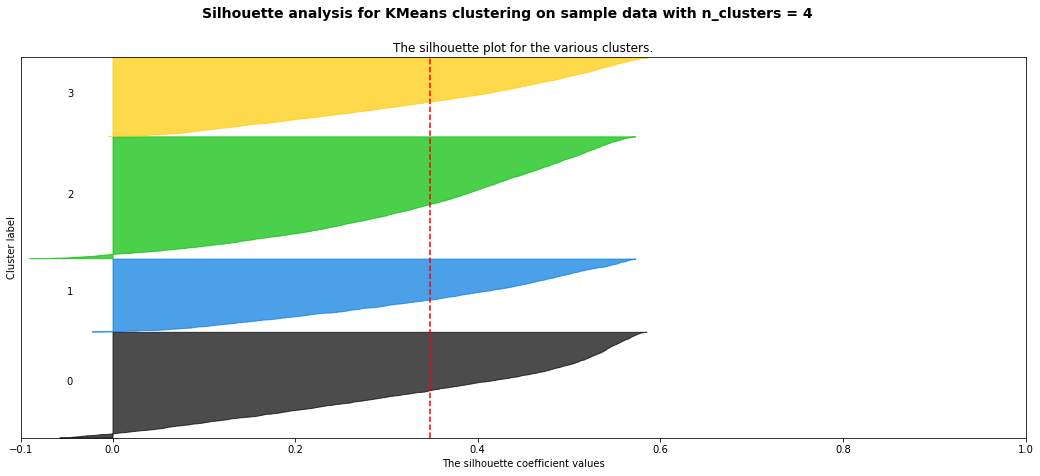

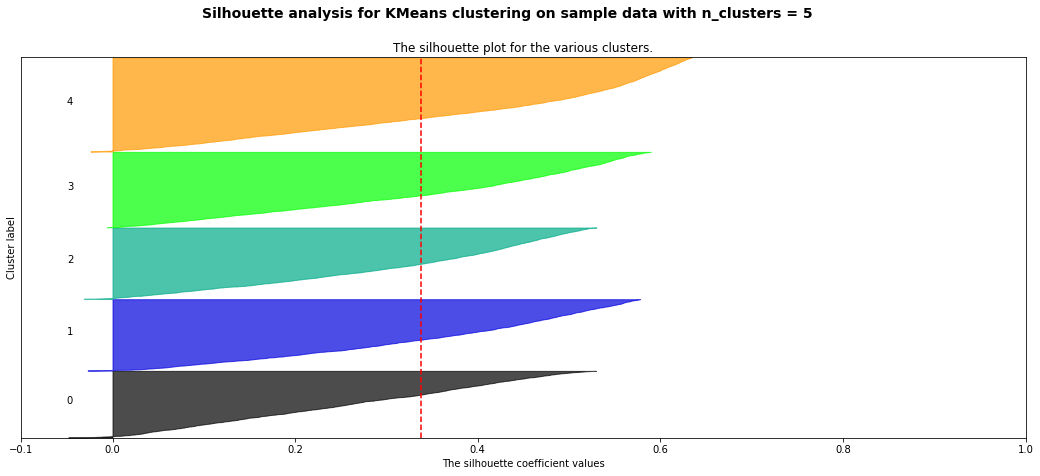

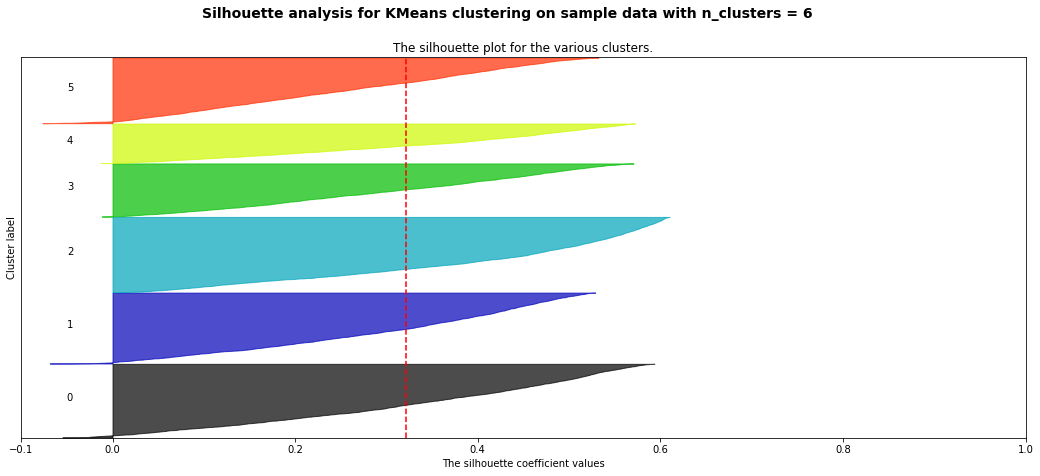

In [39]:
range_n_clusters = [2, 3, 4, 5, 6]
X = reduced_data.copy()
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [ ]:
clusterer = KMeans(n_clusters=2, random_state=10)
clusterer.fit(X)
clusterer.cluster_centers_